In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools

In [3]:
import copy

In [4]:
import HTSeq
import pysam

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

---

## Config

In [6]:
import sys

In [7]:
project_dir = '/home/pmonteagudo/workspace/silencing_project'
if project_dir not in sys.path: 
    sys.path.append(project_dir)
from config_analysis import *

In [8]:
from Util import to_log2_tpm
from Util import long_header

In [9]:
long_header.extend(['gene_length','intron_length'])

- other **directories**

In [10]:
rna_dir

'/gcm-lfs1/pablo/data/rna_silencing/results/xp_data/RNA'

In [11]:
chip_dir

'/gcm-lfs1/pablo/data/rna_silencing/results/xp_data/ChIP'

---

In [12]:
def load_gene_counts(gene_counts_file, index_col='gene_id', gdf='pombase', sample_ids=None):
    
    if gdf == 'pombase':
        rename_cols = {}
    
    # import Gene Counts .csv file as DataFrame 
    counts_df = pd.read_csv(gene_counts_file, sep='\t')

    # rename columns
    counts_df = counts_df.rename(columns=rename_cols)
    
    # contains info about columns being 'samples' or NOT
    header_dict = { ii:('annotation' if ii in long_header else 'sample_col') for ii in counts_df.columns }
    
    if not isinstance(sample_ids, type(None)):
        # select only a subset of samples
        counts_df = counts_df[ [ii for ii in counts_df.columns if (ii in sample_ids or header_dict[ii] == 'annotation')] ]
    
    return counts_df.sort_values('gene_id')
                                                                   

------

# Normalization in Gene Counts: **ChIP-Seq data**

------

In [51]:
params_dict = {
    # sequencing type: ['rna', 'chip']
    'seq_type': 'chip',
    # gene expression matrix: ['gene_count', 'tpm'] 
    'expression': 'tpm',
    #'expression': 'gene_count',
    # batch with corresponding parameters
    'batch': 'xp_data',
    # normalization of counts
    'norm': 'wo_nh-norm',
    # h3k9me2
    'h3k9me2': True,
    #'h3k9me2': False, 
    # log transform data
    'log_transform': True,
    #'log_transform': False,
}

### **A**. Results <font color='blue'> **without** </font> **NH-normalization**

- Import **gene expresion Matrix**: `*_pombe_tpm_matrix.csv`

In [52]:
if params_dict['seq_type'] == 'rna':
    # stranded=True, remove duplicate reads mapping to same gene, count only multimapped if repeat
    xp_data_dir = os.path.join(data_results_dir + '_' + params_dict['norm'], params_dict['batch'], 'RNA')
else:
    # stranded=False, remove duplicate reads mapping to same gene, count only multimapped if repeat
    xp_data_dir = os.path.join(data_results_dir + '_' + params_dict['norm'], params_dict['batch'], 'ChIP')
xp_data_dir

'/gcm-lfs1/pablo/data/rna_silencing/results_wo_nh-norm/xp_data/ChIP'

In [53]:
if (params_dict['seq_type'] == 'chip') and (params_dict['h3k9me2']):
    counts_file = os.path.join(xp_data_dir, 'h3k9me2_' + params_dict['seq_type'] + '_pombe_' + params_dict['expression'] + '_matrix.csv')
else:
    counts_file = os.path.join(xp_data_dir, params_dict['seq_type'] + '_pombe_' + params_dict['expression'] + '_matrix.csv')
counts_file

'/gcm-lfs1/pablo/data/rna_silencing/results_wo_nh-norm/xp_data/ChIP/h3k9me2_chip_pombe_tpm_matrix.csv'

In [54]:
if params_dict['batch'] == 'gene_count':
    # for raw gene counts
    counts_df = load_gene_counts(counts_file, index_col='gene_id', gdf='pombase')
else:
    # for tpm
    #counts_df = load_gene_counts(counts_file, index_col='gene_id', gdf='pombase', as_int=False)
    counts_df = load_gene_counts(counts_file, index_col='gene_id', gdf='pombase')
counts_df

,gene_id,seqid,type,start,end,strand,gene_name,cds_length,utr_length,intron_length,...,302_H3K9me2_1,324_H3K9me2_1,491_H3K9me2_1,504_H3K9me2_1,510_H3K9me2_1,530_H3K9me2_1,638_H3K9me2_1,WT_H3K9me2_1,chip-fake-reads_simulated-data_1,chip-fake-reads_simulated-data_2
0,FP565355_region_1..2120,mating_type_region,region,1,2120,+,NaN,NaN,NaN,NaN,...,408.094181,4502.883538,4993.117682,3063.305824,5711.894487,2515.868824,4165.457917,3124.282423,581.140715,581.140715
1,FP565355_region_15417..15473,mating_type_region,region,15417,15473,+,NaN,NaN,NaN,NaN,...,1162.048668,1971.046770,1686.235695,7319.396234,7398.231799,2747.824806,8045.427287,3527.447203,147.177306,147.177306
2,FP565355_region_15474..15608,mating_type_region,region,15474,15608,+,NaN,NaN,NaN,NaN,...,1391.168477,6279.042506,7482.761671,13815.154482,14955.159873,6049.474767,15653.804910,9781.204416,588.709225,588.709225
3,FP565355_region_15609..16735,mating_type_region,region,15609,16735,+,NaN,NaN,NaN,NaN,...,439.435683,2448.427202,5792.039436,2234.060733,5488.584094,2627.398594,6195.784590,3577.713987,441.531919,441.531919
4,FP565355_region_16736..16794,mating_type_region,region,16736,16794,+,NaN,NaN,NaN,NaN,...,242.514505,4121.908333,2797.902190,9192.532044,4486.233712,2686.762033,10219.535118,2041.416254,588.709225,588.709225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7013,dg1a,I,gene,3761000,3764500,+,dg1_plus,3501.0,NaN,NaN,...,58234.743863,96152.109937,48565.266936,112852.707168,112718.195628,48103.172703,4709.563541,89743.227845,1185.774983,1185.774983
7014,dg1b,I,gene,3761000,3764500,-,dg1_minus,3501.0,NaN,NaN,...,58234.743863,96152.109937,48565.266936,112852.707168,112718.195628,48103.172703,4709.563541,89743.227845,1185.774983,1185.774983
7015,dh1a,I,gene,3753000,3757000,+,dh1_plus,4001.0,NaN,NaN,...,59047.863616,64496.167096,42670.309302,72909.101415,92407.529966,38165.098682,5199.304858,67757.508482,912.894055,912.894055
7016,dh1b,I,gene,3753000,3757000,-,dh1_minus,4001.0,NaN,NaN,...,59047.863616,64496.167096,42670.309302,72909.101415,92407.529966,38165.098682,5199.304858,67757.508482,912.894055,912.894055


In [55]:
counts_df.shape

(7018, 24)

- **Log-transform** and filter for **Heterochromatic** and **Protein coding** (mRNA) genes

In [56]:
if (params_dict['log_transform']):
    #counts_df = to_log2_tpm(counts_df) ## default shift = 1
    counts_df = to_log2_tpm(counts_df, gene_id_col='gene_id', shift=1)

    # Keep only Heterochromatic genes and  protein coding genes
    #counts_df = counts_df[(counts_df['type'] == 'gene') | (counts_df['category'] == 'repeat')]
    counts_df = counts_df[(counts_df['bio_type'] == 'mRNA') | (counts_df['category'] == 'repeat')]

counts_df.head()

,gene_name,gene_id,end,category,seqid,strand,utr_length,start,cds_length,gene_length,...,302_H3K9me2_1,324_H3K9me2_1,491_H3K9me2_1,504_H3K9me2_1,510_H3K9me2_1,530_H3K9me2_1,638_H3K9me2_1,WT_H3K9me2_1,chip-fake-reads_simulated-data_1,chip-fake-reads_simulated-data_2
0,NaN,FP565355_region_1..2120,2120,repeat,mating_type_region,+,NaN,1,NaN,2120,...,8.676289,12.136954,12.286014,11.581345,12.480006,11.297414,12.024606,11.609771,9.185224,9.185224
1,NaN,FP565355_region_15417..15473,15473,repeat,mating_type_region,+,NaN,15417,NaN,57,...,10.183696,10.945478,10.720446,12.837706,12.853160,11.424599,12.974133,11.784818,7.211181,7.211181
2,NaN,FP565355_region_15474..15608,15608,repeat,mating_type_region,+,NaN,15474,NaN,135,...,10.443118,12.616559,12.869548,13.754068,13.868452,12.562833,13.934318,13.255944,9.203860,9.203860
3,NaN,FP565355_region_15609..16735,16735,repeat,mating_type_region,+,NaN,15609,NaN,1127,...,8.782788,11.258229,12.500105,11.126098,12.422481,11.359968,12.597304,11.805226,8.789638,8.789638
4,NaN,FP565355_region_16736..16794,16794,repeat,mating_type_region,+,NaN,16736,NaN,59,...,7.927864,12.009447,11.450645,13.166404,12.131611,11.392190,13.319183,10.996061,9.203860,9.203860


In [57]:
counts_df.shape

(5159, 24)

- Select `sample_id`s for samples present in `counts_df`

In [58]:
#sample_ids = [ii for ii in counts_df.columns if ii != 'gene_id']
sample_ids = [ss for ss in counts_df.columns if ss not in long_header]
len(sample_ids)
#sample_ids

11

- Select only `gene_id` and `sample_id`'s

In [59]:
counts_df = counts_df[['gene_id'] + sample_ids]

In [60]:
#counts_df.shape

### **B**. Results <font color='blue'> **with** </font> **NH-normalization**

- Import **gene expresion Matrix**: `*_pombe_tpm_matrix.csv`

In [61]:
if params_dict['seq_type'] == 'rna':
    # stranded=True, remove duplicate reads mapping to same gene, count only multimapped if repeat (divide by NH)
    norm_xp_data_dir = rna_dir
    #norm_xp_data_dir = os.path.join(data_results_dir, params_dict['batch'], 'RNA')
else:
    # stranded=False, remove duplicate reads mapping to same gene, count only multimapped if repeat (divide by NH)
    norm_xp_data_dir = chip_dir
    #norm_xp_data_dir = os.path.join(data_results_dir, params_dict['batch'], 'ChIP')
norm_xp_data_dir

'/gcm-lfs1/pablo/data/rna_silencing/results/xp_data/ChIP'

In [62]:
if (params_dict['seq_type'] == 'chip') and (params_dict['h3k9me2']):
    norm_counts_file = os.path.join(norm_xp_data_dir,  'h3k9me2_' + params_dict['seq_type'] + '_pombe_' + params_dict['expression'] + '_matrix.csv')
else:
    norm_counts_file = os.path.join(norm_xp_data_dir, params_dict['seq_type'] + '_pombe_' + params_dict['expression'] + '_matrix.csv')
norm_counts_file

'/gcm-lfs1/pablo/data/rna_silencing/results/xp_data/ChIP/h3k9me2_chip_pombe_tpm_matrix.csv'

In [63]:
if params_dict['batch'] == 'gene_count':
    # for raw gene counts
    norm_counts_df = load_gene_counts(norm_counts_file, index_col='gene_id', gdf='pombase', sample_ids=sample_ids)
else:
    # for tpm
    #norm_counts_df = load_gene_counts(norm_counts_file, index_col='gene_id', gdf='pombase', sample_ids=sample_ids, as_int=False)
    norm_counts_df = load_gene_counts(norm_counts_file, index_col='gene_id', gdf='pombase', sample_ids=sample_ids) 

norm_counts_df

,gene_id,seqid,type,start,end,strand,gene_name,cds_length,utr_length,intron_length,...,302_H3K9me2_1,324_H3K9me2_1,491_H3K9me2_1,504_H3K9me2_1,510_H3K9me2_1,530_H3K9me2_1,638_H3K9me2_1,WT_H3K9me2_1,chip-fake-reads_simulated-data_1,chip-fake-reads_simulated-data_2
0,FP565355_region_1..2120,mating_type_region,region,1,2120,+,NaN,NaN,NaN,NaN,...,164.336295,2307.272915,1834.725481,2253.683503,4356.955689,940.184246,1336.748605,2025.518399,149.274199,149.274199
1,FP565355_region_15417..15473,mating_type_region,region,15417,15473,+,NaN,NaN,NaN,NaN,...,1861.995895,4003.507846,2457.144726,21265.246117,22372.720331,4068.558264,10208.141304,9067.231621,149.292221,149.292221
2,FP565355_region_15474..15608,mating_type_region,region,15474,15608,+,NaN,NaN,NaN,NaN,...,557.280874,3188.432197,2725.927999,10034.388453,11306.337056,2239.284006,4965.437098,6285.596982,149.292221,149.292221
3,FP565355_region_15609..16735,mating_type_region,region,15609,16735,+,NaN,NaN,NaN,NaN,...,234.708310,1657.714345,2813.343195,2163.559662,5532.608345,1296.749856,2620.430311,3065.480457,149.292221,149.292221
4,FP565355_region_16736..16794,mating_type_region,region,16736,16794,+,NaN,NaN,NaN,NaN,...,97.147612,2093.061997,1019.260035,6676.829964,3391.663539,994.536464,3241.669300,1311.854788,149.292221,149.292221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7013,dg1a,I,gene,3761000,3764500,+,dg1_plus,3501.0,NaN,NaN,...,11139.692310,21691.546349,8659.794733,36676.451155,42290.611930,8818.917732,682.669596,27952.456058,149.355127,149.355127
7014,dg1b,I,gene,3761000,3764500,-,dg1_minus,3501.0,NaN,NaN,...,11139.692310,21691.546349,8659.794733,36676.451155,42290.611930,8818.917732,682.669596,27952.456058,149.355127,149.355127
7015,dh1a,I,gene,3753000,3757000,+,dh1_plus,4001.0,NaN,NaN,...,14610.461803,17351.236631,9517.936436,27721.865201,40728.792993,8639.608773,923.452207,24701.222884,149.292221,149.292221
7016,dh1b,I,gene,3753000,3757000,-,dh1_minus,4001.0,NaN,NaN,...,14610.461803,17351.236631,9517.936436,27721.865201,40728.792993,8639.608773,923.452207,24701.222884,149.292221,149.292221


In [64]:
norm_counts_df.shape

(7018, 24)

- **Log-transform** and filter for **Heterochromatic** and **Protein coding** (mRNA) genes

In [65]:
if (params_dict['log_transform']):
    #norm_counts_df = to_log2_tpm(norm_counts_df) ## default shift = 1
    norm_counts_df = to_log2_tpm(norm_counts_df, gene_id_col='gene_id', shift=1)

    # Keep only Heterochromatic genes and  protein coding genes
    #norm_counts_df = norm_counts_df[(norm_counts_df['type'] == 'gene') | (counts_df['category'] == 'repeat')]
    norm_counts_df = norm_counts_df[(norm_counts_df['bio_type'] == 'mRNA') | (norm_counts_df['category'] == 'repeat')]

norm_counts_df.head()

,gene_name,gene_id,end,category,seqid,strand,utr_length,start,cds_length,gene_length,...,302_H3K9me2_1,324_H3K9me2_1,491_H3K9me2_1,504_H3K9me2_1,510_H3K9me2_1,530_H3K9me2_1,638_H3K9me2_1,WT_H3K9me2_1,chip-fake-reads_simulated-data_1,chip-fake-reads_simulated-data_2
0,NaN,FP565355_region_1..2120,2120,repeat,mating_type_region,+,NaN,1,NaN,2120,...,7.369260,11.172598,10.842135,11.138709,12.089436,9.878333,10.385591,10.984788,7.231454,7.231454
1,NaN,FP565355_region_15417..15473,15473,repeat,mating_type_region,+,NaN,15417,NaN,57,...,10.863409,11.967409,11.263354,14.376278,14.449518,11.990656,13.317574,13.146606,7.231627,7.231627
2,NaN,FP565355_region_15474..15608,15608,repeat,mating_type_region,+,NaN,15474,NaN,135,...,9.124847,11.639084,11.413061,13.292809,13.464972,11.129466,12.277996,12.618064,7.231627,7.231627
3,NaN,FP565355_region_15609..16735,16735,repeat,mating_type_region,+,NaN,15609,NaN,1127,...,7.880859,10.695850,11.458583,11.079858,12.434005,10.341797,11.356138,11.582368,7.231627,7.231627
4,NaN,FP565355_region_16736..16794,16794,repeat,mating_type_region,+,NaN,16736,NaN,59,...,6.616881,11.032088,9.994721,12.705164,11.728203,9.959330,11.662966,10.358492,7.231627,7.231627


In [66]:
norm_counts_df.shape

(5159, 24)

- Select only `gene_id` and `sample_id`'s

In [67]:
norm_counts_df = norm_counts_df[['gene_id'] + sample_ids]

In [68]:
#norm_counts_df.shape

### **C**. Merge Results: <font color='blue'> **without** </font>  and <font color='blue'> **with** </font>  **NH-normalization**

- Check for **missing genes**

In [69]:
missing_genes = set(norm_counts_df['gene_id']).symmetric_difference(counts_df['gene_id'])
len(missing_genes)

0

- **Merge** both counts DataFrames

In [70]:
#sample_ids = list(set(sample_ids).symmetric_difference(norm_counts_df.columns))
#sample_ids = list(set(sample_ids).intersection(norm_counts_df.columns))
#sample_ids

In [71]:
# use concat with `set_index` with 'gene_id' in both DataFrames, then `swaplevel` with `sort_index` for expected MultiIndex in columns:
merged_xp = (pd.concat([counts_df.set_index('gene_id'), 
                norm_counts_df.set_index('gene_id')], 
                axis=1, 
                keys=['wo_norm', 'norm'], 
                sort=True)
        .swaplevel(0, 1, axis=1)
        .sort_index(axis=1, ascending=[True, False])
        )

In [72]:
merged_xp

301_H3K9me2_1            302_H3K9me2_1  \
                                   wo_norm       norm       wo_norm   
gene_id                                                               
FP565355_region_1..2120           8.144838   7.770820      8.676289   
FP565355_region_15417..15473     10.089078  11.701693     10.183696   
FP565355_region_15474..15608     10.488893  10.102709     10.443118   
FP565355_region_15609..16735      9.567602   9.596110      8.782788   
FP565355_region_16736..16794      6.936350   6.553472      7.927864   
...                                    ...        ...           ...   
SPRPTCENA.4                      17.160078  15.559783     16.086106   
dg1a                             17.000530  15.471866     15.829617   
dg1b                             17.000530  15.471866     15.829617   
dh1a                             16.630883  15.345470     15.849622   
dh1b                             16.630883  15.345470     15.849622   

                                        324_H3K9me2_1             \
                                   norm       wo_norm       norm   
gene_id                                                            
FP565355_region_1..2120        7.369260     12.136954  11.172598   
FP565355_region_15417..15473  10.863409     10.945478  11.967409   
FP565355_region_15474..15608   9.124847     12.616559  11.639084   
FP565355_region_15609..16735   7.880859     11.258229  10.695850   
FP565355_region_16736..16794   6.616881     12.009447  11.032088   
...                                 ...           ...        ...   
SPRPTCENA.4                   13.657590     16.878727  14.689923   
dg1a                          13.443551     16.553046  14.404912   
dg1b                          13.443551     16.553046  14.404912   
dh1a                          13.834813     15.976948  14.082834   
dh1b                          13.834813     15.976948  14.082834   

                             491_H3K9me2_1            504_H3K9me2_1  \
                                   wo_norm       norm       wo_norm   
gene_id                                                               
FP565355_region_1..2120          12.286014  10.842135     11.581345   
FP565355_region_15417..15473     10.720446  11.263354     12.837706   
FP565355_region_15474..15608     12.869548  11.413061     13.754068   
FP565355_region_15609..16735     12.500105  11.458583     11.126098   
FP565355_region_16736..16794     11.450645   9.994721     13.166404   
...                                    ...        ...           ...   
SPRPTCENA.4                      15.791995  13.211908     17.014930   
dg1a                             15.567667  13.080284     16.784094   
dg1b                             15.567667  13.080284     16.784094   
dh1a                             15.380979  13.216585     16.153831   
dh1b                             15.380979  13.216585     16.153831   

                                         ... 530_H3K9me2_1             \
                                   norm  ...       wo_norm       norm   
gene_id                                  ...                            
FP565355_region_1..2120       11.138709  ...     11.297414   9.878333   
FP565355_region_15417..15473  14.376278  ...     11.424599  11.990656   
FP565355_region_15474..15608  13.292809  ...     12.562833  11.129466   
FP565355_region_15609..16735  11.079858  ...     11.359968  10.341797   
FP565355_region_16736..16794  12.705164  ...     11.392190   9.959330   
...                                 ...  ...           ...        ...   
SPRPTCENA.4                   15.336742  ...     15.743017  13.200185   
dg1a                          15.162606  ...     15.553874  13.106549   
dg1b                          15.162606  ...     15.553874  13.106549   
dh1a                          14.758789  ...     15.220004  13.076917   
dh1b                          14.758789  ...     15.220004  13.076917   

                             638_H3K9me2_1            WT_H3K9me

In [73]:
# https://stackoverflow.com/questions/40225683/how-to-simply-add-a-column-level-to-a-pandas-dataframe
#merged_xp.columns = pd.MultiIndex.from_tuples(map(lambda x: ( x, '_'.join(x.split('_')[:-1]) ), merged_xp.columns))

In [74]:
#merged_xp = pd.merge(counts_df, xp_parastou_df, on='gene_id', how='outer')
#merged_xp

In [75]:
merged_xp.shape

(5159, 22)

------

## Visualization:  <font color='blue'> **without** </font>  vs <font color='blue'> **with** </font>  **NH-normalization**

------

- **Visualization**: `scatter_plot`

In [76]:
import math
import numpy as np

In [77]:
import collections

In [78]:
def map_color(ratio, n_clusters):
    
    clust = np.linspace(0, 1, n_clusters)
    # init vars
    lower_bound = 0
    color = 0
    
    for ii, upper_bound in enumerate(np.linspace(0, math.pi/2, n_clusters)):
        
        if (ratio > math.tan(lower_bound)) and (ratio <= math.tan(upper_bound)):
            color = clust[ii]

        ii =+ 1
        lower_bound = upper_bound
    
    return color

In [79]:
def correlation_scatter_plot(merged_xp, x, y, sample_ids=None, n_clusters=6, n_max=50000, out_dir=None):

    deviate_genes = collections.Counter( )
    
    if isinstance(sample_ids, type(None)):
        sample_ids = merged_xp.columns.get_level_values(0).unique()
                      
    for sample_id in sample_ids:

        print(' sample_id: {}'.format(sample_id))

        # remove nan's
        df = merged_xp[sample_id].dropna()

        #df['x'].plot.kde()
        #df['y'].plot.kde()

        # filter extreme counts
        df = df[ (df[x] < n_max) & (df[y] < n_max) ]

        ## Compute ratios: 
        df['ratio'] =  df[y] / df[x]
        
        # add color column
        #df['color'] = df['ratio'].apply(lambda x: map_color(x)
        df['color'] = df['ratio'].apply(lambda x: map_color(x, n_clusters))

        #df['diff_count'] = abs(df[y] - df[x])
        #df.sort_values('diff_count', na_position='first')

        # print distribution ammong clusters
        df_by_type = df['color'].value_counts().sort_index()
        #print(df_by_type, '\n')
        
        #for gg in df[df['color'] >= 0.8].index.tolist():
        for gg in df[df['color'] <= 0.4].index.tolist():
            deviate_genes[gg] += 1
        
        ## ------------
        ## Scatter Plot
        ## ------------
        
        plot_lim = max(max(df[x]), max(df[y]))

        plt.figure()
        #merged_xp.plot.scatter(x = 'count', y = sample_name, xlim=(0, 1000), ylim=(0, 1000))
        df.plot.scatter(x=x, y=y, c='color', 
                        colormap='viridis',
                        xlim=(0, plot_lim),
                        ylim=(0, plot_lim))
        plt.title(' sample_id: {} (genes={})'.format(sample_id, df_by_type.sum()))
        
        ## y = x - perfect correlation
        xx = np.linspace(0, plot_lim, 1000)
        plt.plot(xx, xx, '--k') # dashdot black
        
        if not isinstance(out_dir, type(None)):
            plt.savefig(os.path.join(out_dir, sample_id + '_' + x + '_vs_' + y + '.pdf' ))
            
        #plt.close() 

    return deviate_genes

- Scatter plots: **all Genes**

In [80]:
if params_dict['expression'] == 'gene_count':
    fig_dir = os.path.join(plots_dir, 'gxp_plots')
else:
    fig_dir = os.path.join(plots_dir, 'tpm_plots')

In [81]:
if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir
fig_dir

'/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-06-21/tpm_plots'

 sample_id: 301_H3K9me2_1


<Figure size 432x288 with 0 Axes>

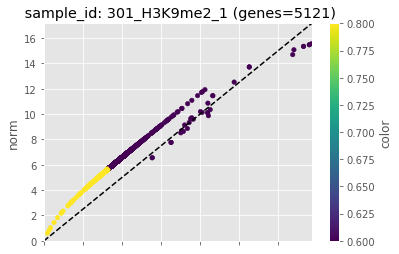

In [82]:
deviate_genes = correlation_scatter_plot(merged_xp, x='wo_norm', y ='norm', n_max=50000, sample_ids=sample_ids[0:1], out_dir=fig_dir)
#deviate_genes = correlation_scatter_plot(merged_xp, x='wo_norm', y ='norm', n_max=50000, out_dir=fig_dir)

In [48]:
#df[df['color'] > 0 ]

In [50]:
len(deviate_genes)
deviate_genes

Counter({'FP565355_region_16736..16794': 1, 'FP565355_region_4498..4556': 1})

- Genes conntaining big deviations across all samples (or many samples):
    - After using equivalent `'count_mode' = 'union'` to Parastou (instead of intersectiom-empty)
    - Only **10 genes** contain big differences, most of which can be explained by differences between `ensembl` and `Pombase` **annotation**.
    - Unexplained differences: (ChIP-seq)
        - SPNCRNA.390 (This it's in the region where we MAT locus htc_genes are defined)
        - SPNCRNA.1306

In [ ]:
weird_genes = ['SPNCRNA.390', 'SPNCRNA.1306'] # still not explained by differences in annotation

In [ ]:
#big_deviate_genes = {k:v for k,v in deviate_genes.items() if v >= 40}
big_deviate_genes = {k:v for k,v in deviate_genes.items() if v >= 20}
#big_deviate_genes

In [ ]:
#missing_genes

In [ ]:
#big_deviate_genes_df = merged_xp_rna[merged_xp_rna.index.isin(big_deviate_genes) & ~merged_xp_rna.index.isin(missing_genes)]
big_deviate_genes_df = merged_xp_rna[merged_xp_rna.index.isin(weird_genes)]

## many deviates are due to 0 counts, we require ~ 1 count per sample
#big_deviate_genes_df[big_deviate_genes_df.sum(1) > 100] 
#big_deviate_genes_df[big_deviate_genes_df.xs('htseq', level=1, axis=1).sum(1) > 52]
#big_deviate_genes_df[big_deviate_genes_df.xs('parastou', level=1, axis=1).sum(1) > 52]
#big_deviate_genes_df[(big_deviate_genes_df.xs('htseq', level=1, axis=1).sum(1) > 100) & (big_deviate_genes_df.xs('parastou', level=1, axis=1).sum(1) > 100)]
big_deviate_genes_df

In [ ]:
big_deviate_genes_df.xs('htseq', level=1, axis=1).sum(1)
big_deviate_genes_df.xs('parastou', level=1, axis=1).sum(1)

## Investigate **heterochromatic genes**

In [ ]:
import viz_strands ## get deg1, deg2 and non_degraded

In [ ]:
## centromeric genes: `deg1`
old_deg1 = ['dh1', 'dg1']
deg1 = viz_strands.deg1

## subtelomeric genes: `deg2`
old_deg2 = ['SPAC212.11', 'SPAC212.10']
deg2 = viz_strands.deg2

# Mating type region (MTR) gene counts
deg3 = ['MAT2', 'MAT3', 'MAT1']

## rest of Heterochromatic genes, including mat: `deg3`
# non_degraded = ['SPAC212.09c', 'SPNCRNA.70', 'SPAC212.08c', 'SPAC212.07c', 'SPAC212.12', 'SPAC212.06c',
#                 'SPAC212.04c', 'SPAC212.03', 'SPAC212.02', 'SPAC212.01c', 'SPAC977.01', 'SPAC977.18',
#                 'SPAC977.02', 'SPAC977.03', 'SPAC977.04', 'SPAC212.05c', 'MAT2', 'MAT3', 'MAT1']
non_degraded = viz_strands.non_degraded

In [ ]:
old_all_htc_genes = old_deg1 + old_deg2 + deg3 + non_degraded
old_htc_genes = old_deg1 + old_deg2 + deg3

In [ ]:
all_htc_genes = deg1 + deg2 + non_degraded
htc_genes = deg1 + deg2 + deg3

- Show counts for genes of interest: **manual entries Heterochromatic Genes (UNSTRANDED)**

In [ ]:
#merged_xp_rna[(merged_xp_rna.index.isin(old_htc_genes)) | (merged_xp_rna.index.isin(new_htc_genes))]
merged_xp_rna[merged_xp_rna.index.isin(old_htc_genes)]

- Show counts for genes of interest: **manual entries Heterochromatic Genes (STRANDED)**

In [ ]:
merged_xp_rna[merged_xp_rna.index.isin(htc_genes)]

- Show counts for genes of interest: **all Heterochromatic Genes**

In [ ]:
#[xx for xx in merged_xp_rna.columns if '80' in xx[0]]

In [ ]:
#htc_df = merged_xp_rna[merged_xp_rna.index.isin(het_genes)]
#htc_df = merged_xp_rna[merged_xp_rna.index.isin(old_all_htc_genes)]
#htc_df = merged_xp_rna[merged_xp_rna.index.isin(all_htc_genes)]
htc_df = merged_xp_rna[merged_xp_rna.index.isin(non_degraded)].xs([xx for xx in merged_xp_rna.columns if '80' in xx[0]], axis=1)
htc_df

In [ ]:
htc_df.shape

- Scatter plots: **all Genes**

In [ ]:
if params_dict['expression'] == 'gene_count':
    plot_dir = os.path.join(xp_data_dir, 'gxp_htc_plots')
else:
    plot_dir = os.path.join(xp_data_dir, 'tpm_htc_plots')

In [ ]:
if not os.path.isdir(plot_dir):    
    !mkdir -p $plot_dir
plot_dir

In [ ]:
htc_deviate_genes = correlation_scatter_plot(htc_df, n_max=50000, out_dir=plot_dir)